In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

from optuna.samplers import TPESampler
import optuna

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('seaborn-v0_8-pastel')

In [3]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

original_data = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

In [4]:
train_data.head(10)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
5,5,Male,18.128249,1.748524,51.552595,yes,yes,2.919751,3.000000,Sometimes,no,2.137550,no,1.930033,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
6,6,Male,29.883021,1.754711,112.725005,yes,yes,1.991240,3.000000,Sometimes,no,2.000000,no,0.000000,0.696948,Sometimes,Automobile,Obesity_Type_II
7,7,Male,29.891473,1.750150,118.206565,yes,yes,1.397468,3.000000,Sometimes,no,2.000000,no,0.598655,0.000000,Sometimes,Automobile,Obesity_Type_II
8,8,Male,17.000000,1.700000,70.000000,no,yes,2.000000,3.000000,Sometimes,no,3.000000,yes,1.000000,1.000000,no,Public_Transportation,Overweight_Level_I
9,9,Female,26.000000,1.638836,111.275646,yes,yes,3.000000,3.000000,Sometimes,no,2.632253,no,0.000000,0.218645,Sometimes,Public_Transportation,Obesity_Type_III


In [5]:
train_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,20758.000000,10378.500000,5992.462780,0.000000,5189.250000,10378.500000,15567.750000,20757.000000
Age,20758.000000,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.000000,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.000000,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.000000,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.000000,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.000000,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.000000,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.000000,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000


In [6]:
test_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [7]:
test_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,13840.000000,27677.500000,3995.408198,20758.000000,24217.750000,27677.500000,31137.250000,34597.000000
Age,13840.000000,23.952740,5.799814,14.000000,20.000000,22.906342,26.000000,61.000000
Height,13840.000000,1.698934,0.088761,1.450000,1.631662,1.700000,1.760710,1.980000
Weight,13840.000000,87.384504,26.111819,39.000000,65.000000,83.952968,111.157811,165.057269
FCVC,13840.000000,2.442898,0.531606,1.000000,2.000000,2.358087,3.000000,3.000000
NCP,13840.000000,2.750610,0.710927,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,13840.000000,2.032044,0.611230,1.000000,1.771781,2.000000,2.552388,3.000000
FAF,13840.000000,0.974532,0.840361,0.000000,0.001086,1.000000,1.571865,3.000000
TUE,13840.000000,0.611033,0.608005,0.000000,0.000000,0.552498,1.000000,2.000000


In [8]:
original_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [9]:
original_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Age,2111.000000,24.312600,6.345968,14.000000,19.947192,22.777890,26.000000,61.000000
Height,2111.000000,1.701677,0.093305,1.450000,1.630000,1.700499,1.768464,1.980000
Weight,2111.000000,86.586058,26.191172,39.000000,65.473343,83.000000,107.430682,173.000000
FCVC,2111.000000,2.419043,0.533927,1.000000,2.000000,2.385502,3.000000,3.000000
NCP,2111.000000,2.685628,0.778039,1.000000,2.658738,3.000000,3.000000,4.000000
CH2O,2111.000000,2.008011,0.612953,1.000000,1.584812,2.000000,2.477420,3.000000
FAF,2111.000000,1.010298,0.850592,0.000000,0.124505,1.000000,1.666678,3.000000
TUE,2111.000000,0.657866,0.608927,0.000000,0.000000,0.625350,1.000000,2.000000


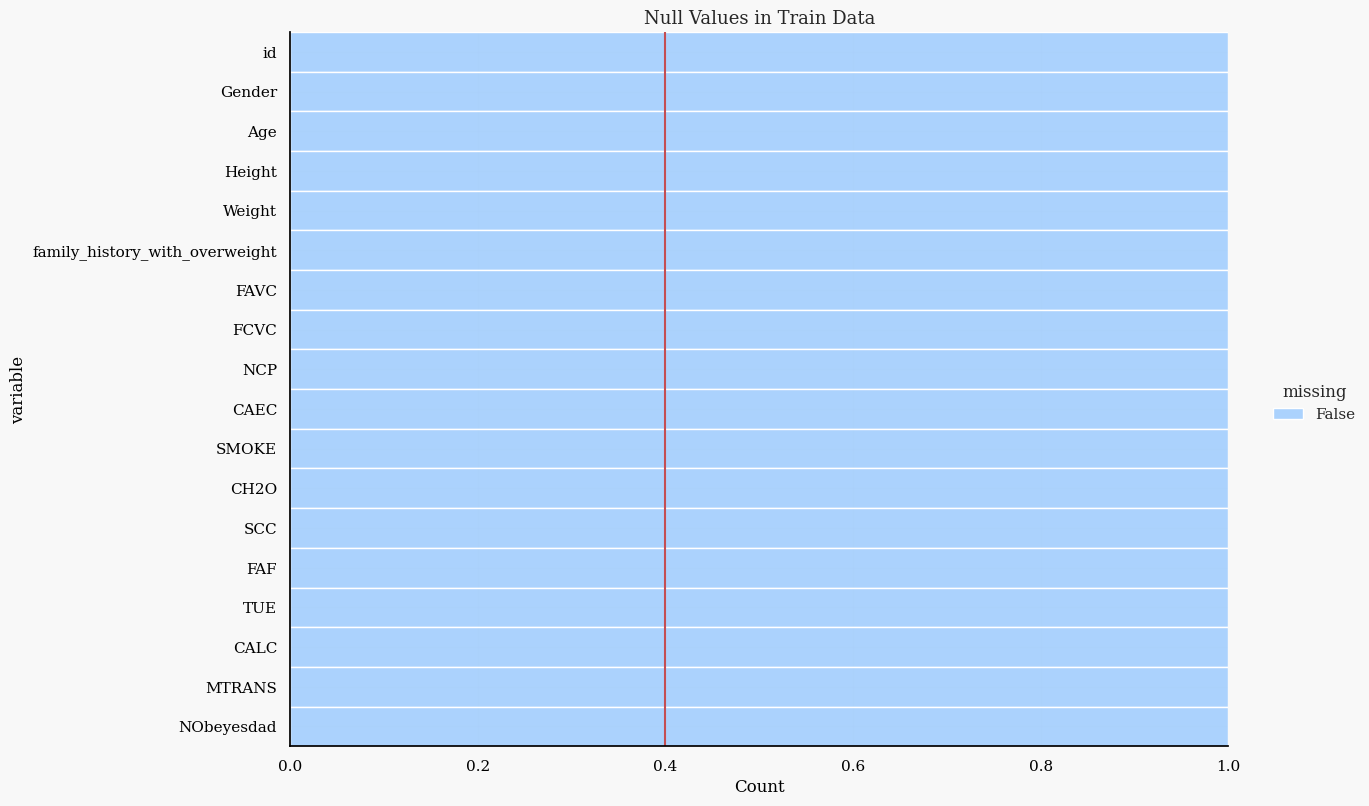

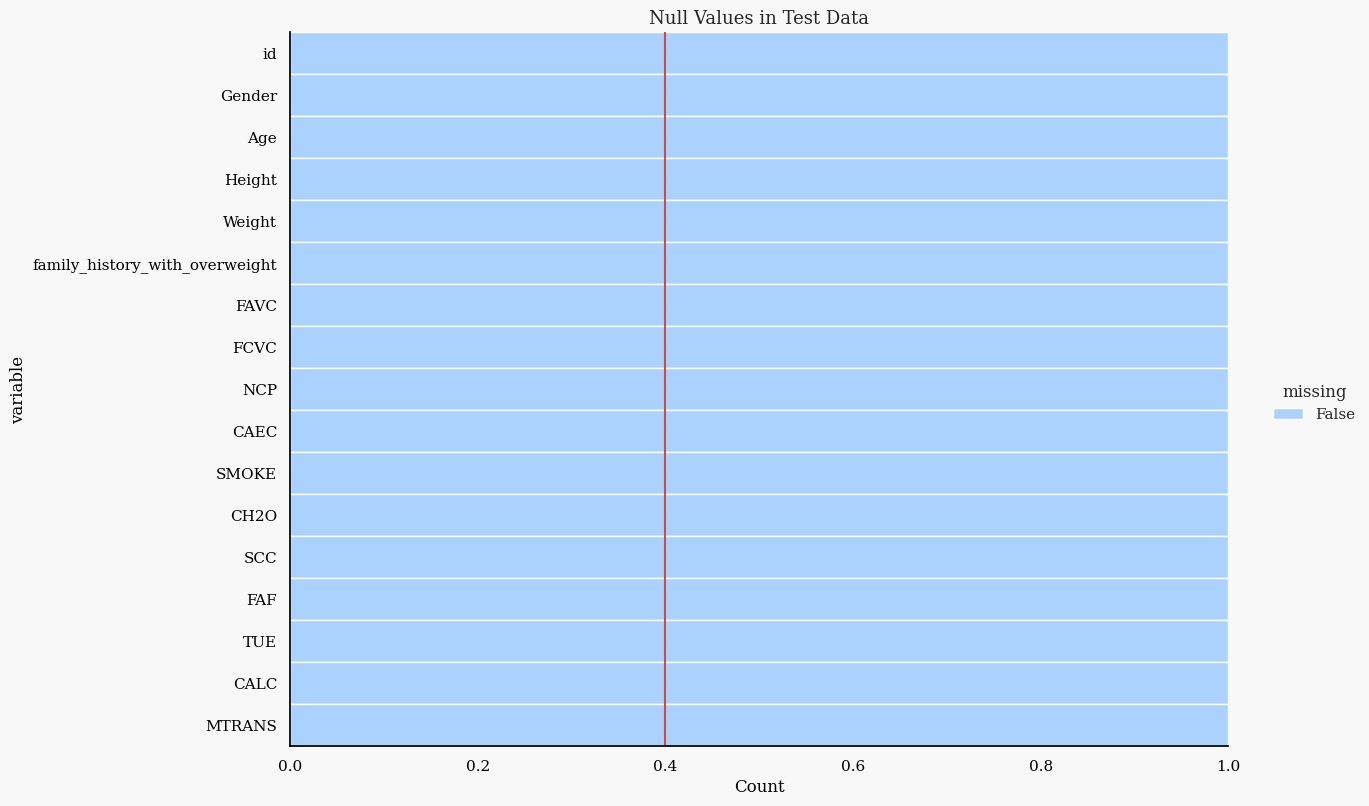

In [10]:
sns.displot(data=train_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Train Data', fontsize=13)
plt.show()

# -------------------------

sns.displot(data=test_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Test Data', fontsize=13)
plt.show()

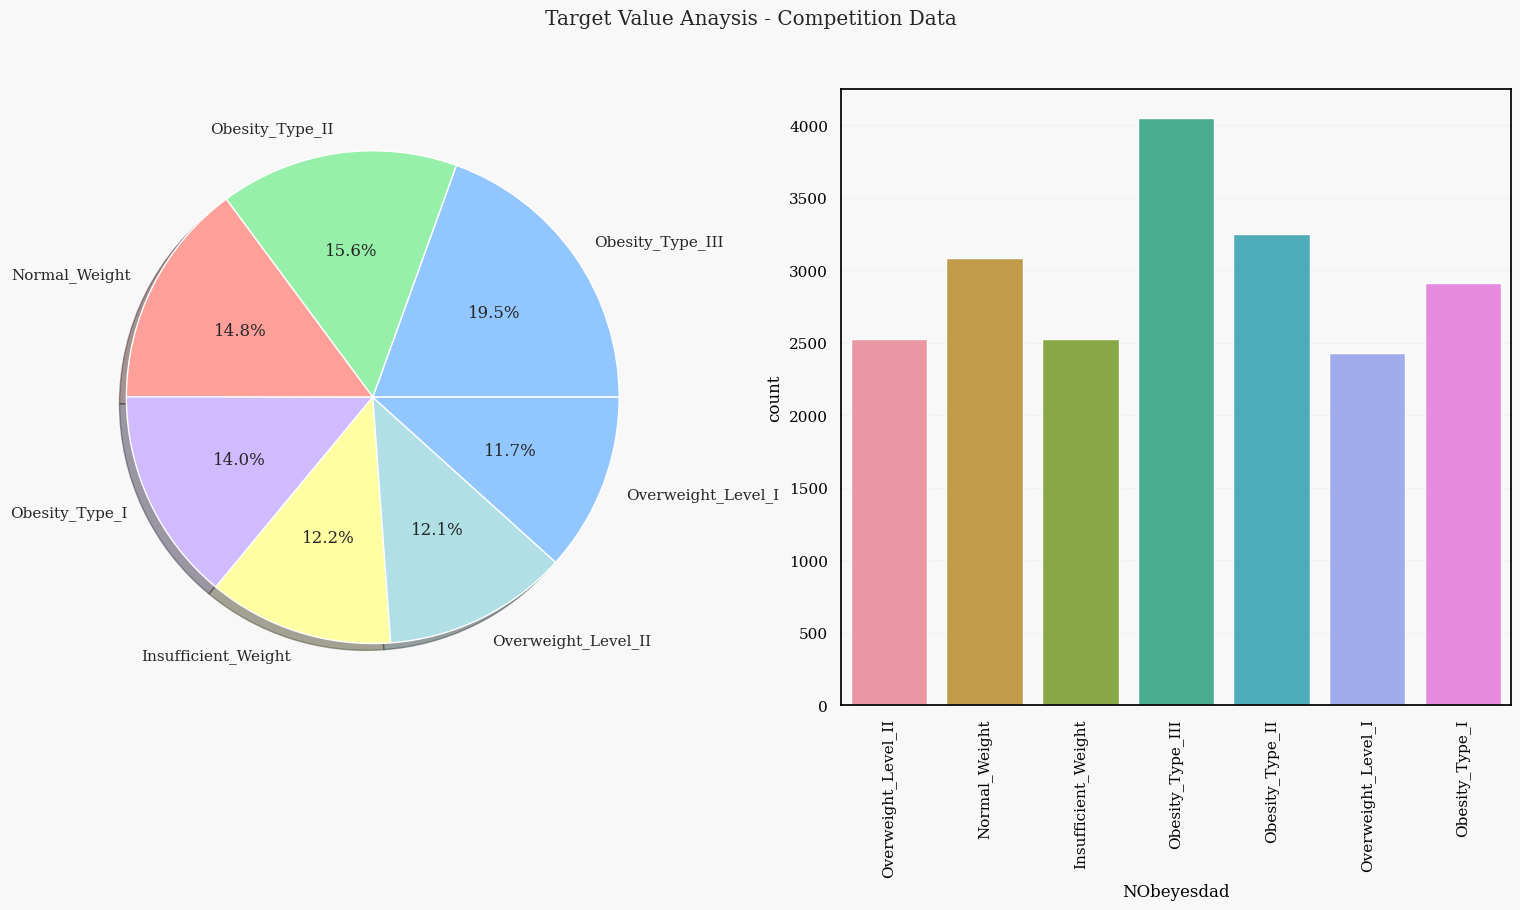

In [11]:
f,ax=plt.subplots(1,2,figsize=(19,8))
train_data['NObeyesdad'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
# ax[0].set_title('Pie-Plot')
ax[0].set_ylabel('')
sns.countplot(x='NObeyesdad',data=train_data,ax=ax[1])
plt.xticks(rotation=90)
# ax[1].set_title('Count-Plot')
plt.suptitle('Target Value Anaysis - Competition Data')
plt.show()

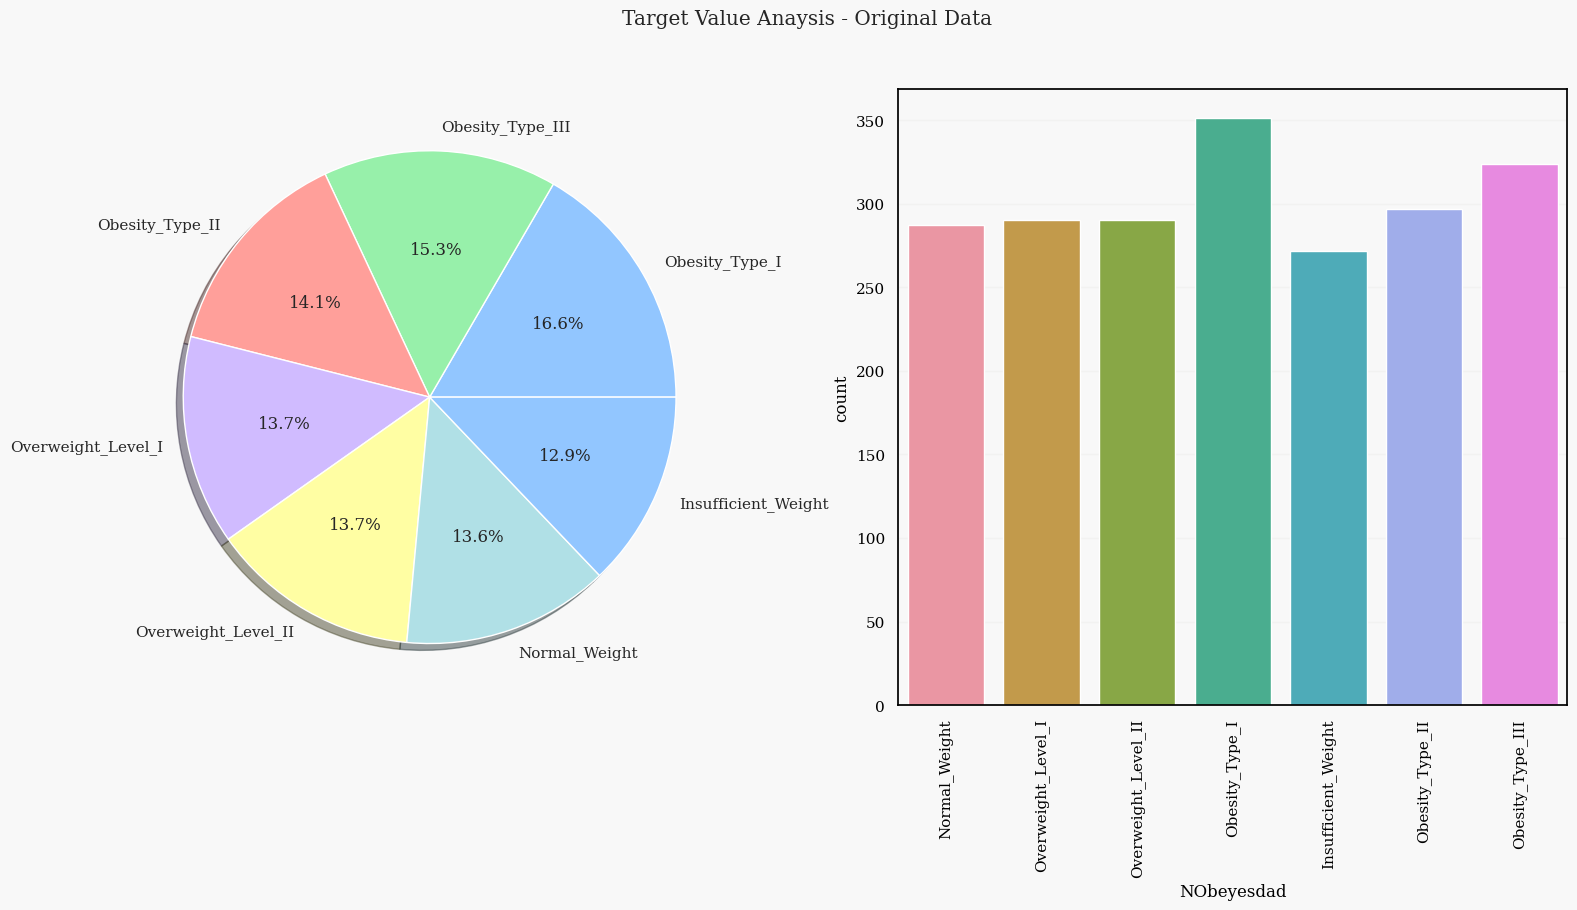

In [12]:
f,ax=plt.subplots(1,2,figsize=(19,8))
original_data['NObeyesdad'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
# ax[0].set_title('Pie-Plot')
ax[0].set_ylabel('')
sns.countplot(x='NObeyesdad',data=original_data,ax=ax[1])
plt.xticks(rotation=90)
# ax[1].set_title('Count-Plot')
plt.suptitle('Target Value Anaysis - Original Data')
plt.show()

In [13]:
# Unique value counts for each column
unique_counts = train_data.nunique()

# Threshold to distinguish continuous and categorical
threshold = 10

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'outcome' from categorical since it's our target variable
if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

print(f"Categorical Variables: {categorical_vars}")
print(f"Continousl/Numerical Variables: {continuous_vars}")

Categorical Variables: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Continousl/Numerical Variables: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


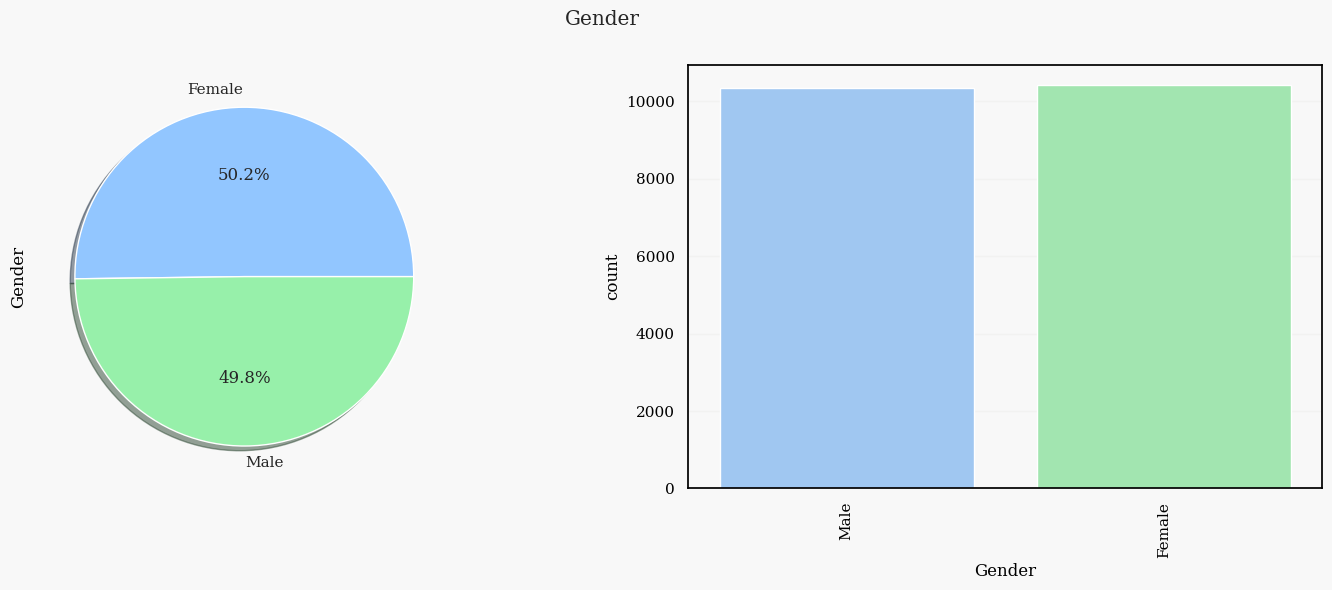

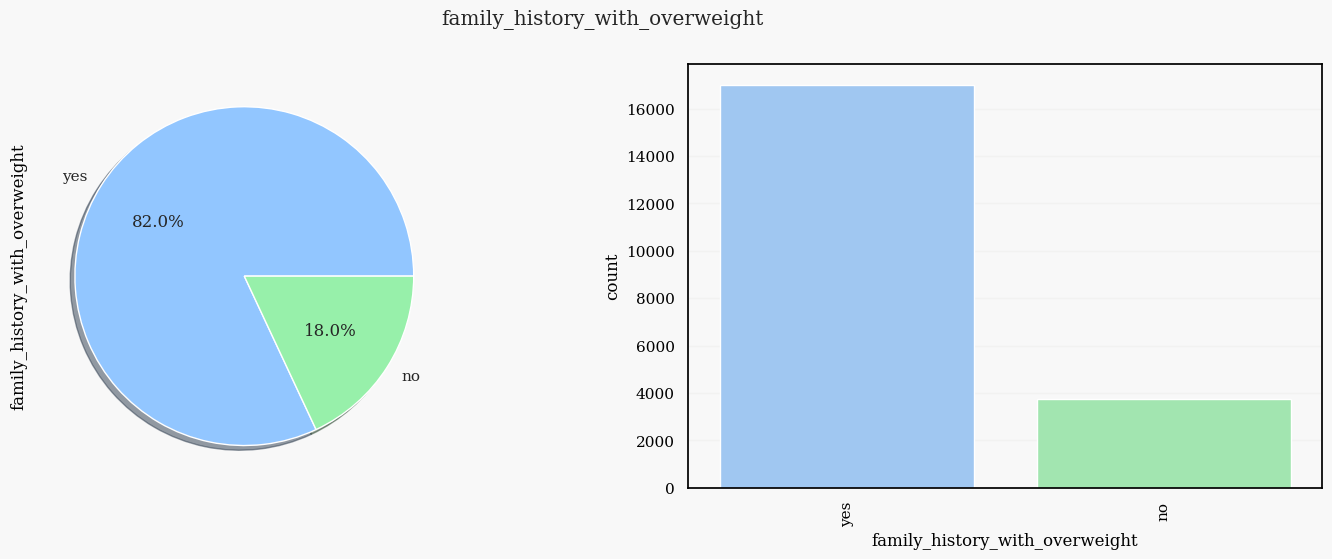

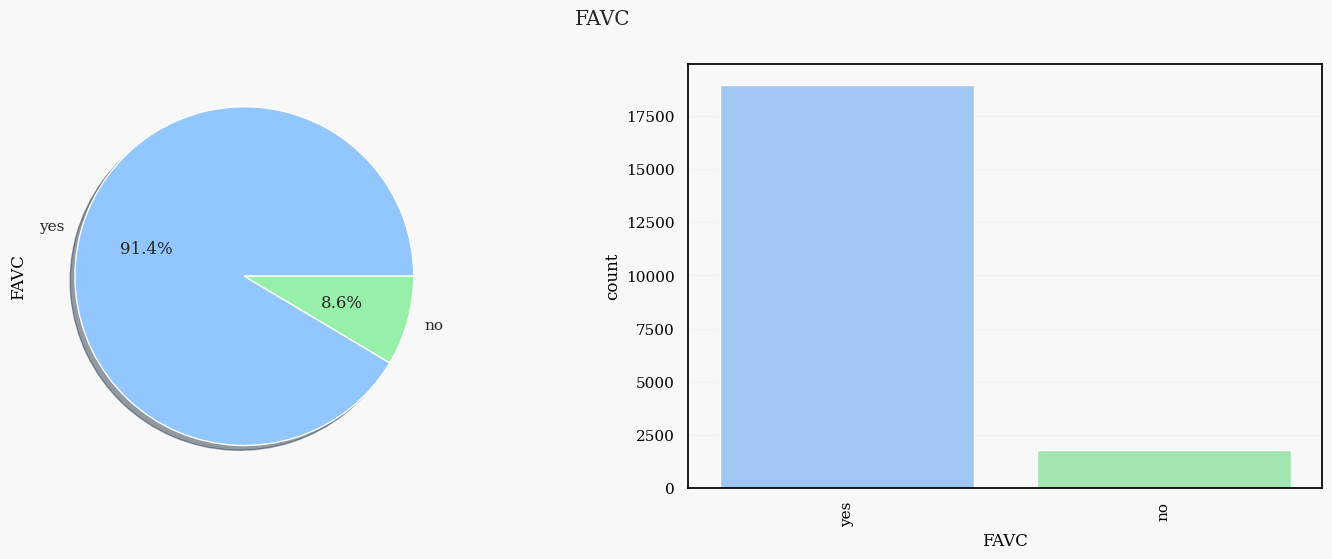

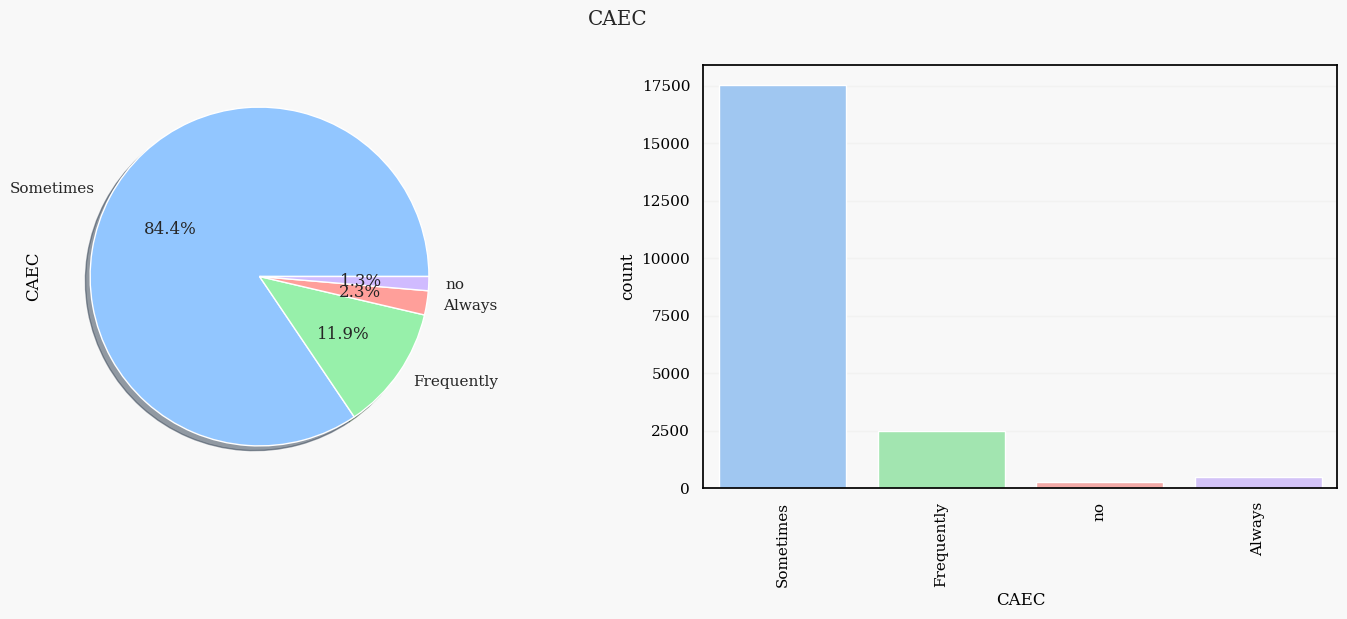

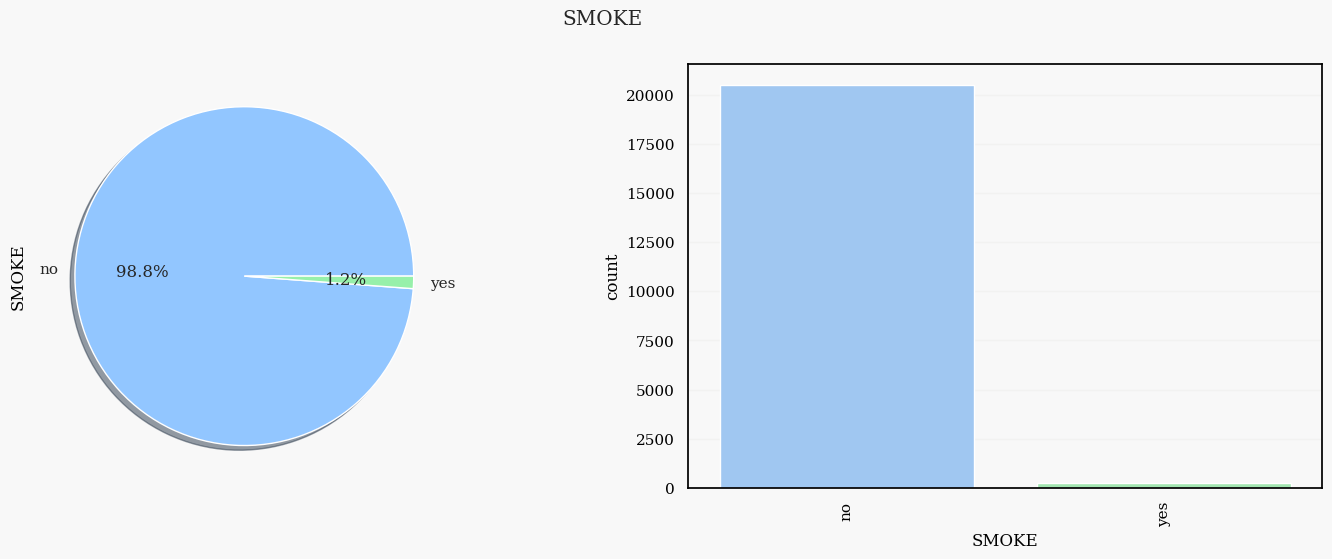

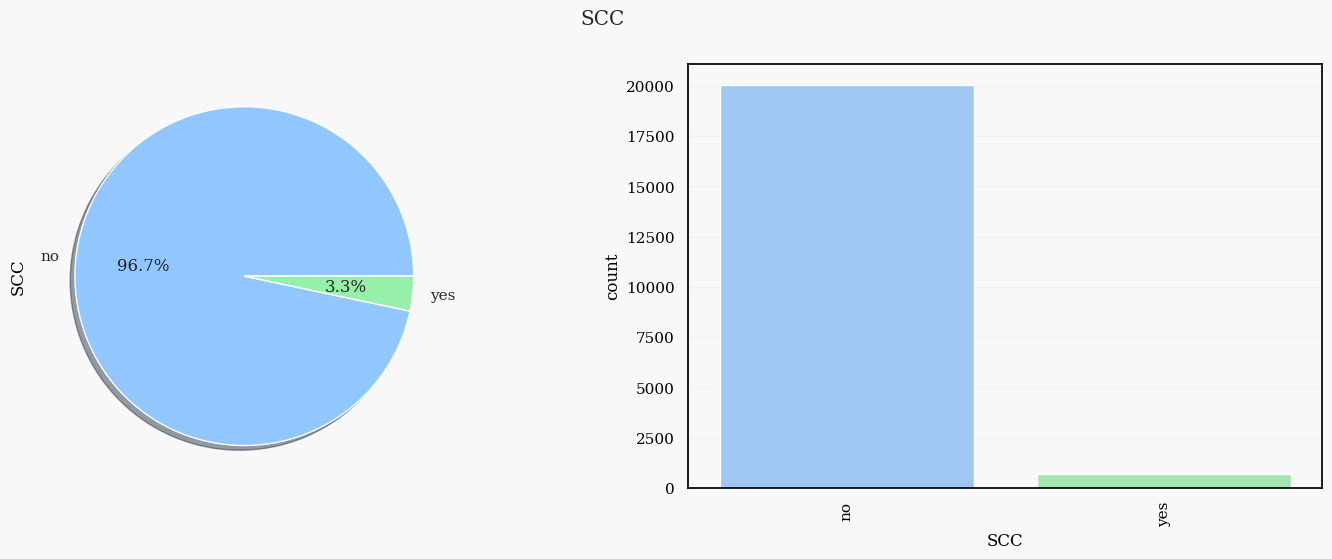

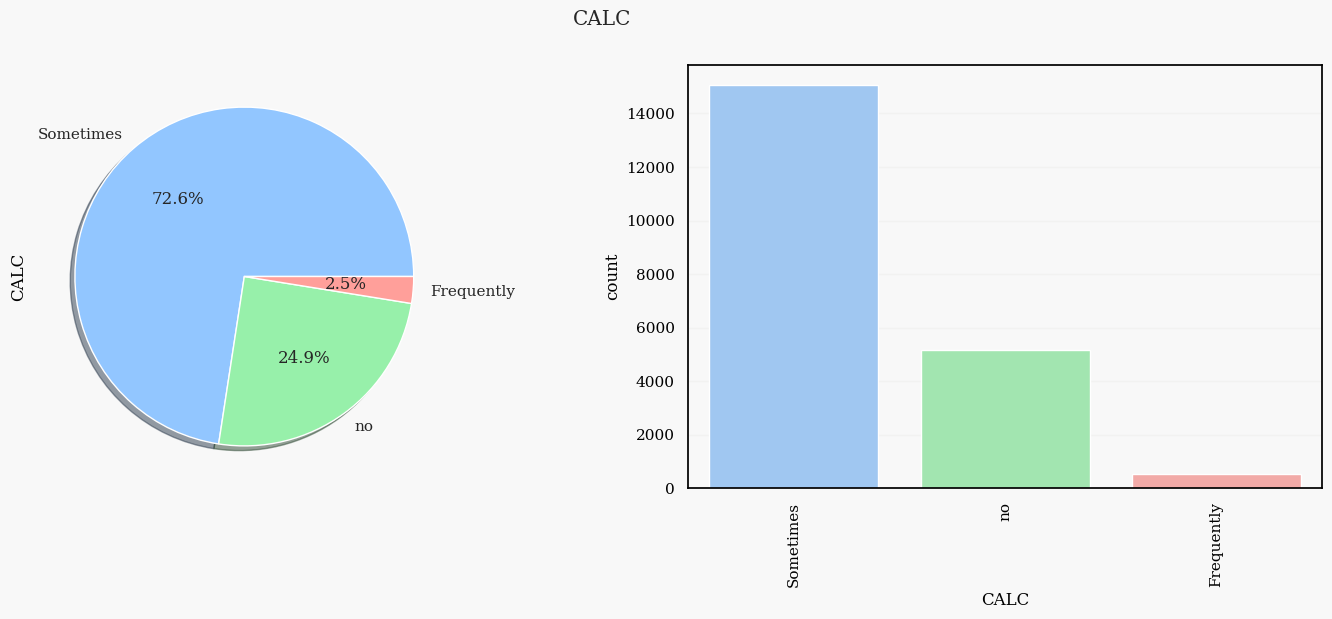

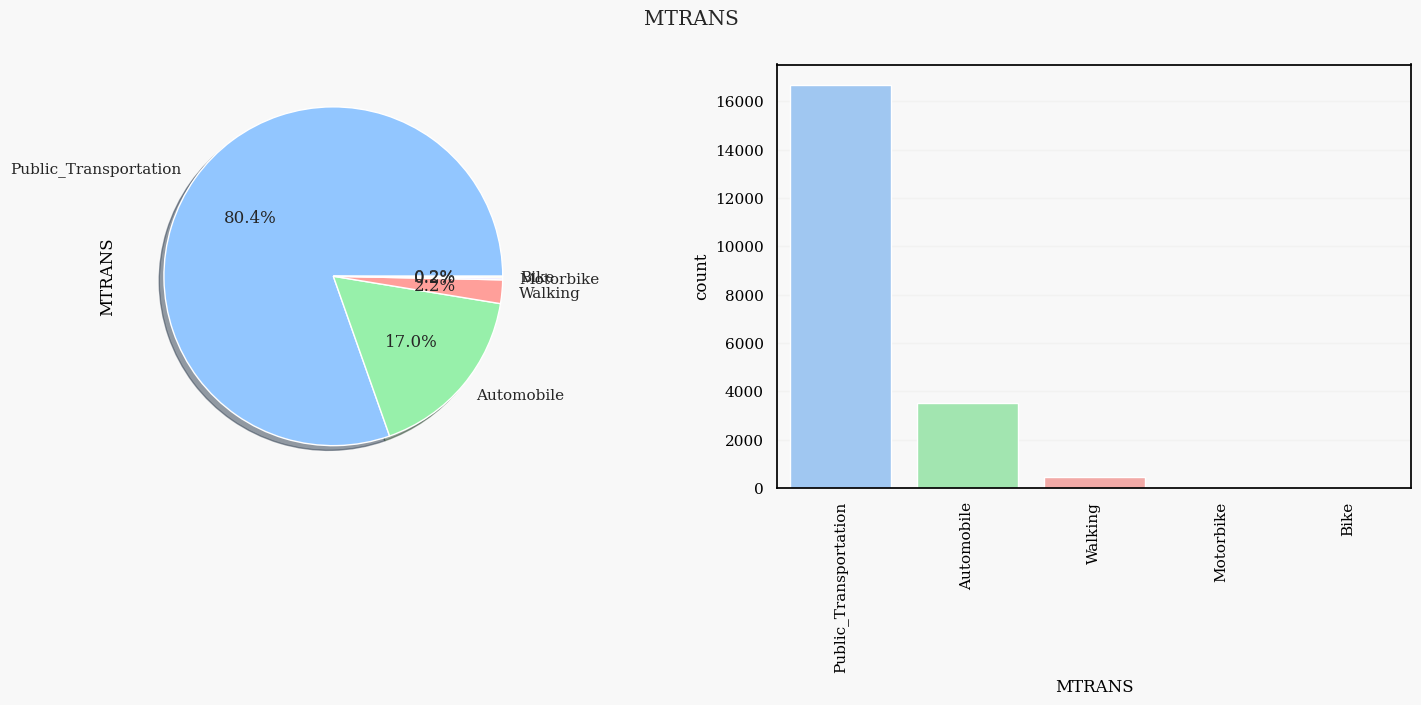

In [14]:
categorical_vars.remove('NObeyesdad')

for column in categorical_vars:
    f,ax=plt.subplots(1,2,figsize=(18,5.5))
    train_data[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=train_data,ax=ax[1])
    plt.xticks(rotation=90)
    plt.suptitle(f'{column}')
    plt.show()

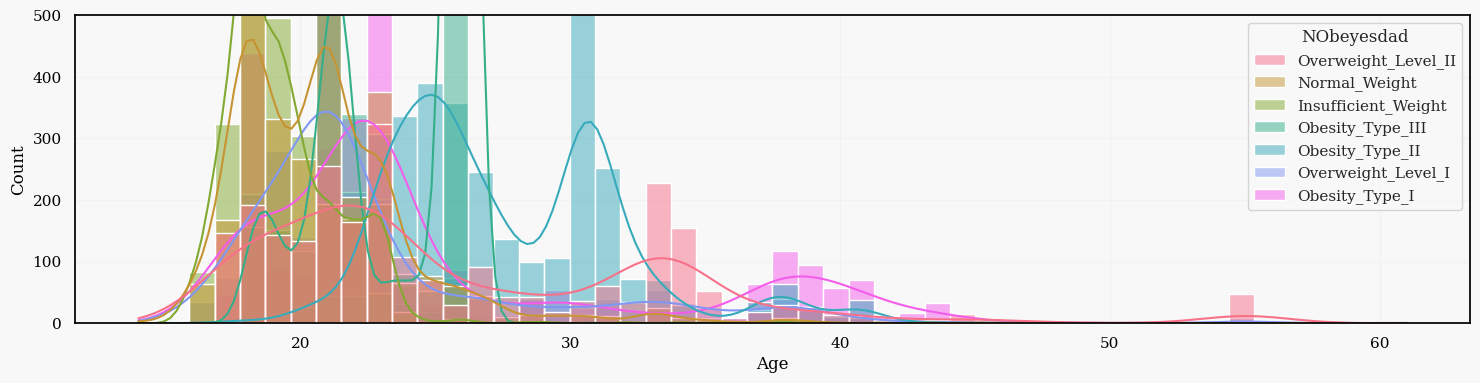

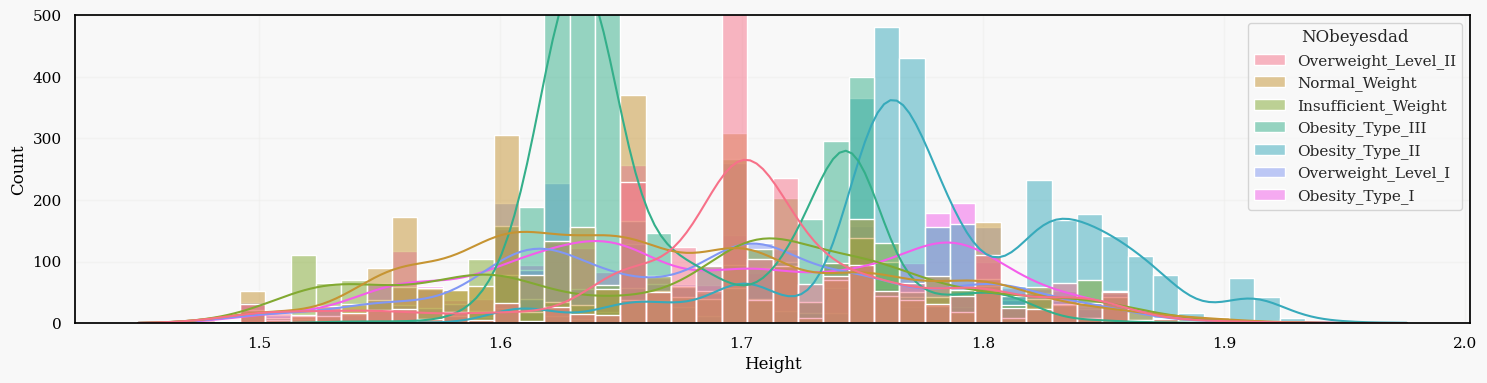

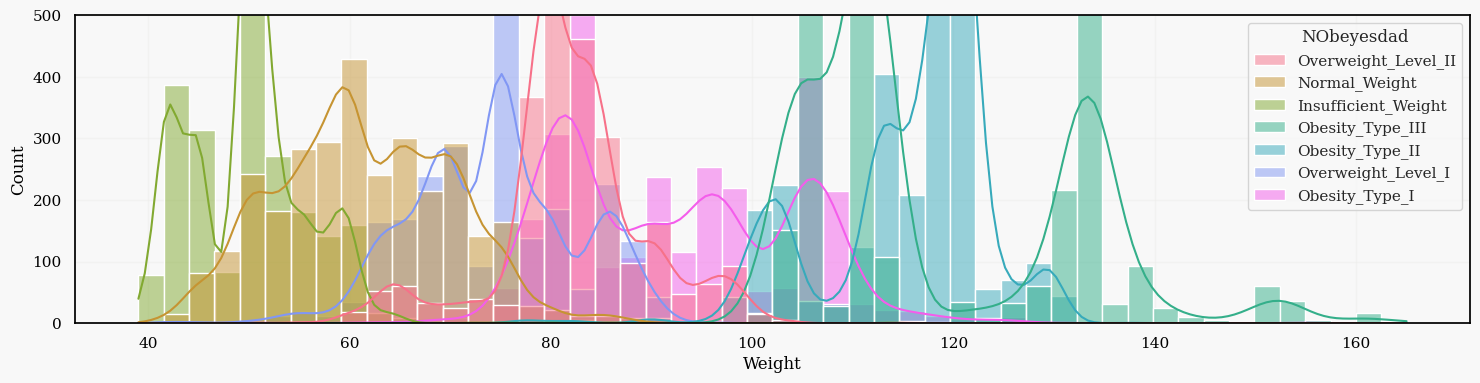

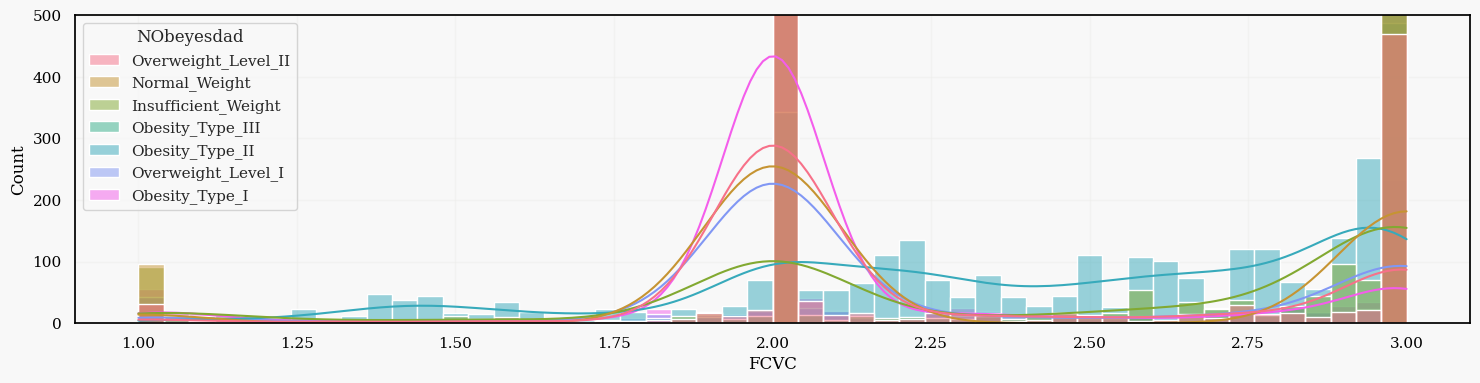

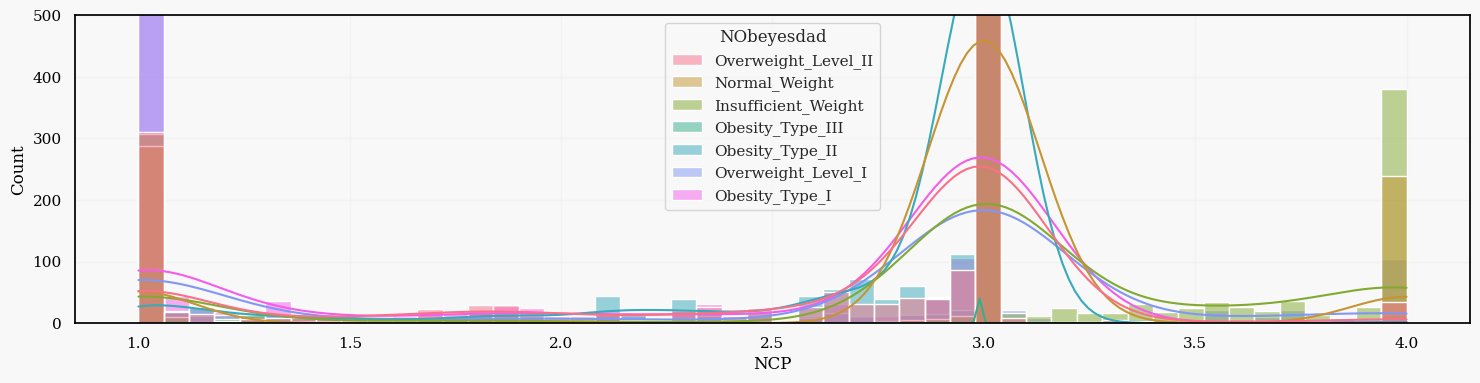

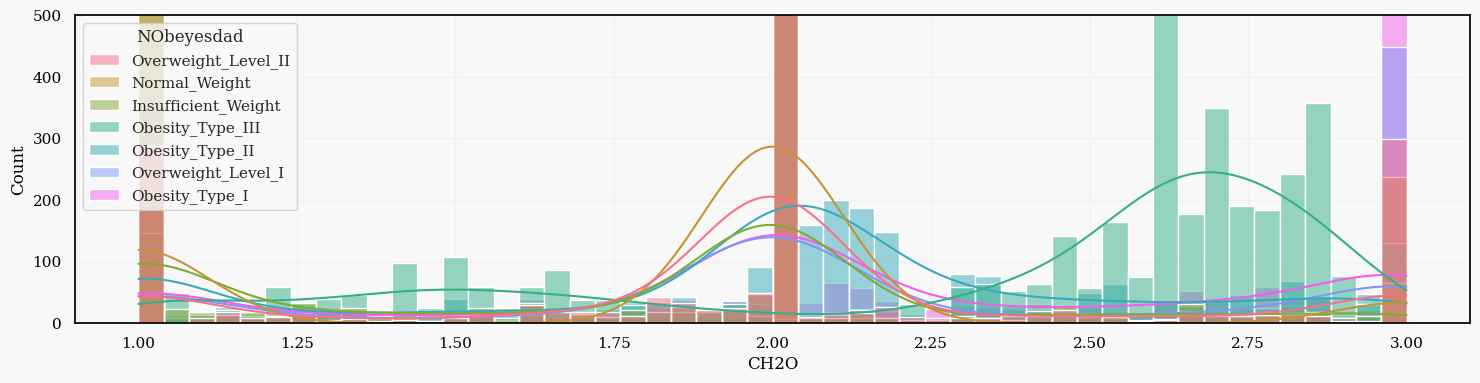

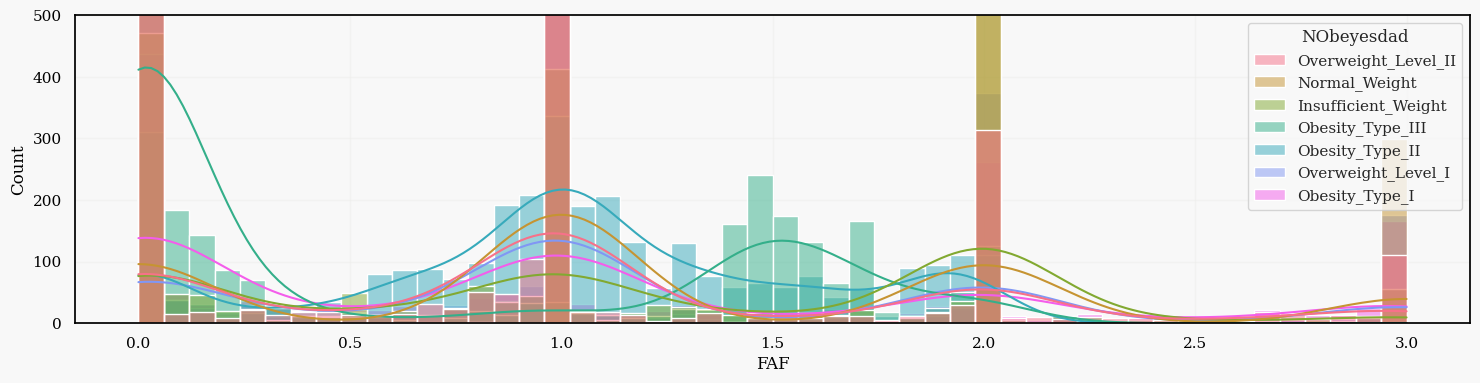

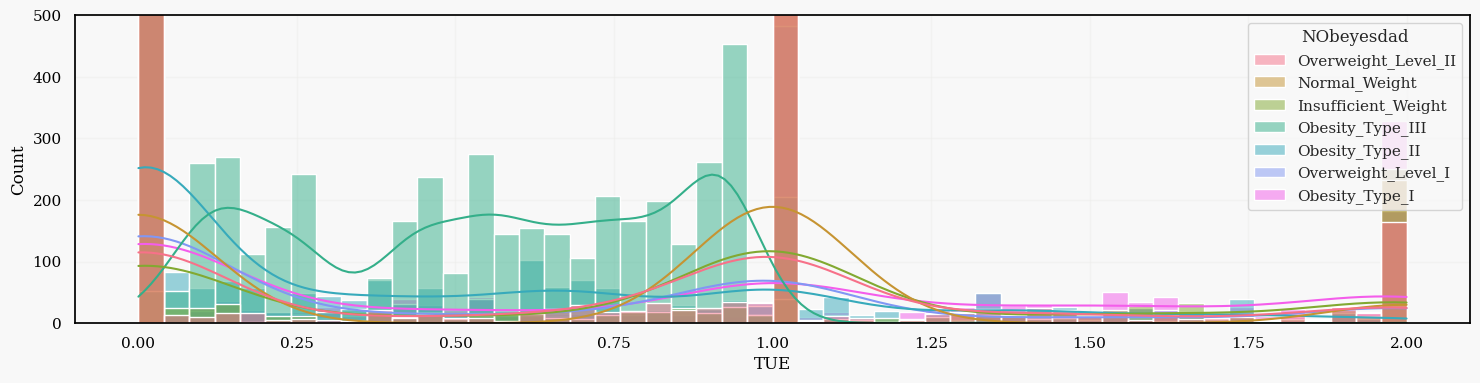

In [15]:
for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=train_data, x=column, hue="NObeyesdad", bins=50, kde=True)
    plt.ylim(0,500)
    plt.show()

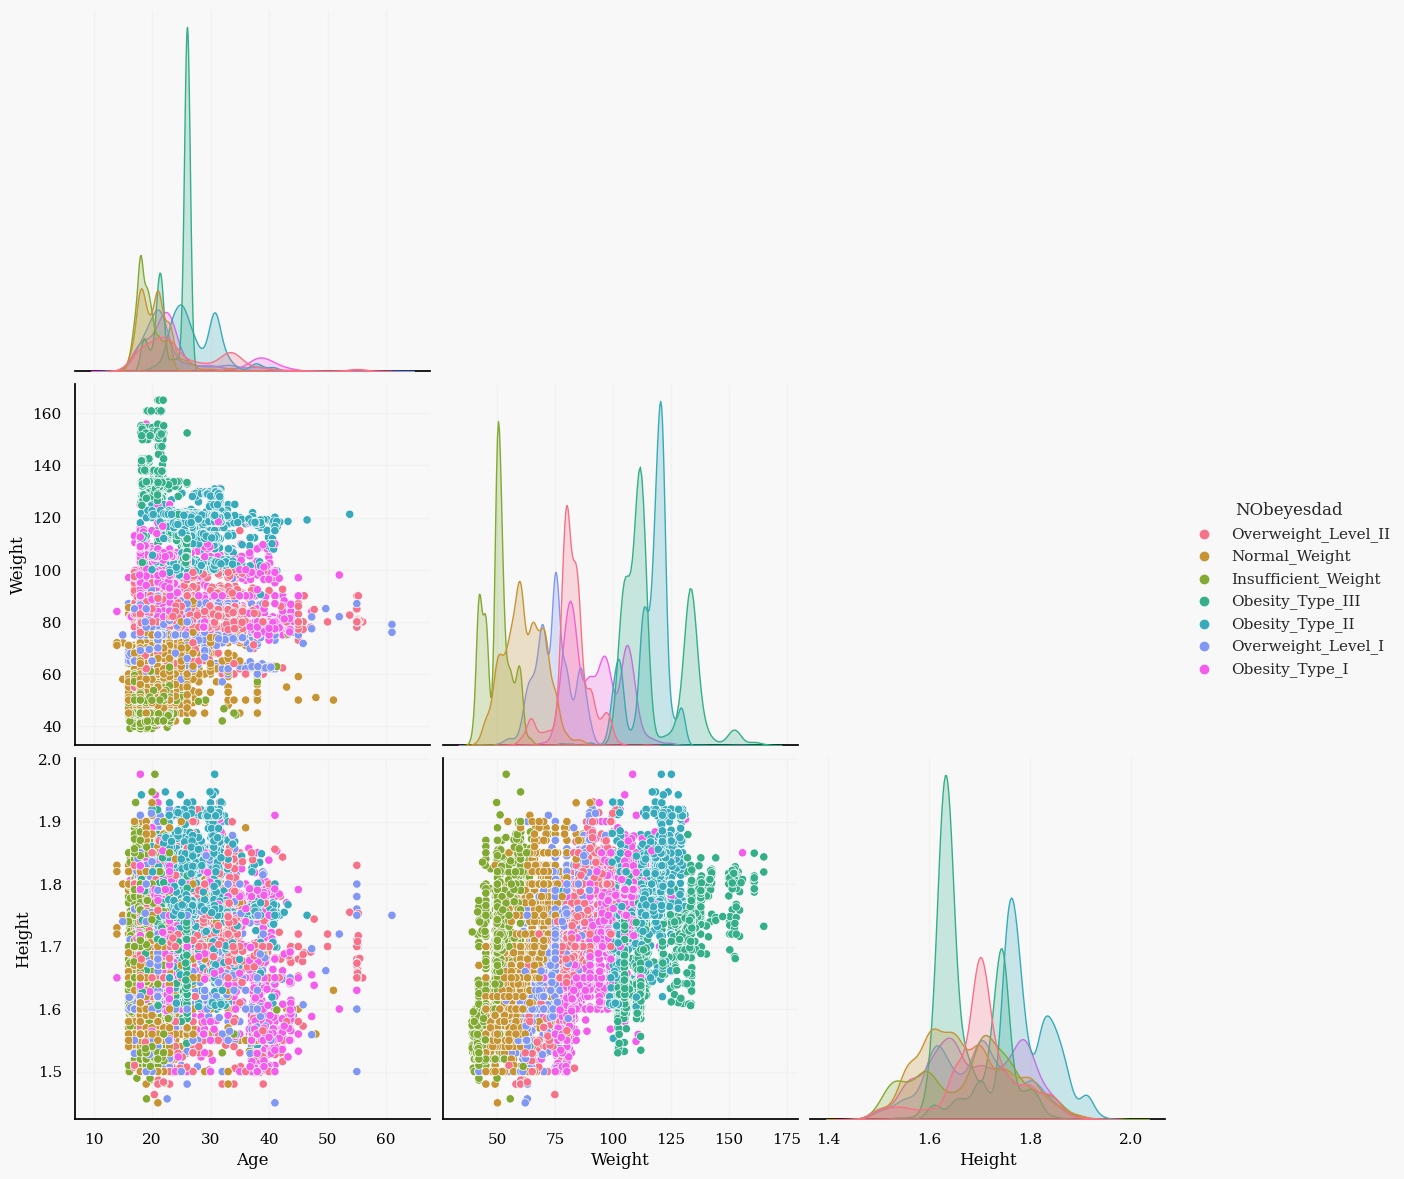

In [16]:
df3 = train_data[['Age', 'Weight', 'Height', 'NObeyesdad']].copy()

sns.pairplot(df3, hue="NObeyesdad", corner=True, size=4)
plt.show()

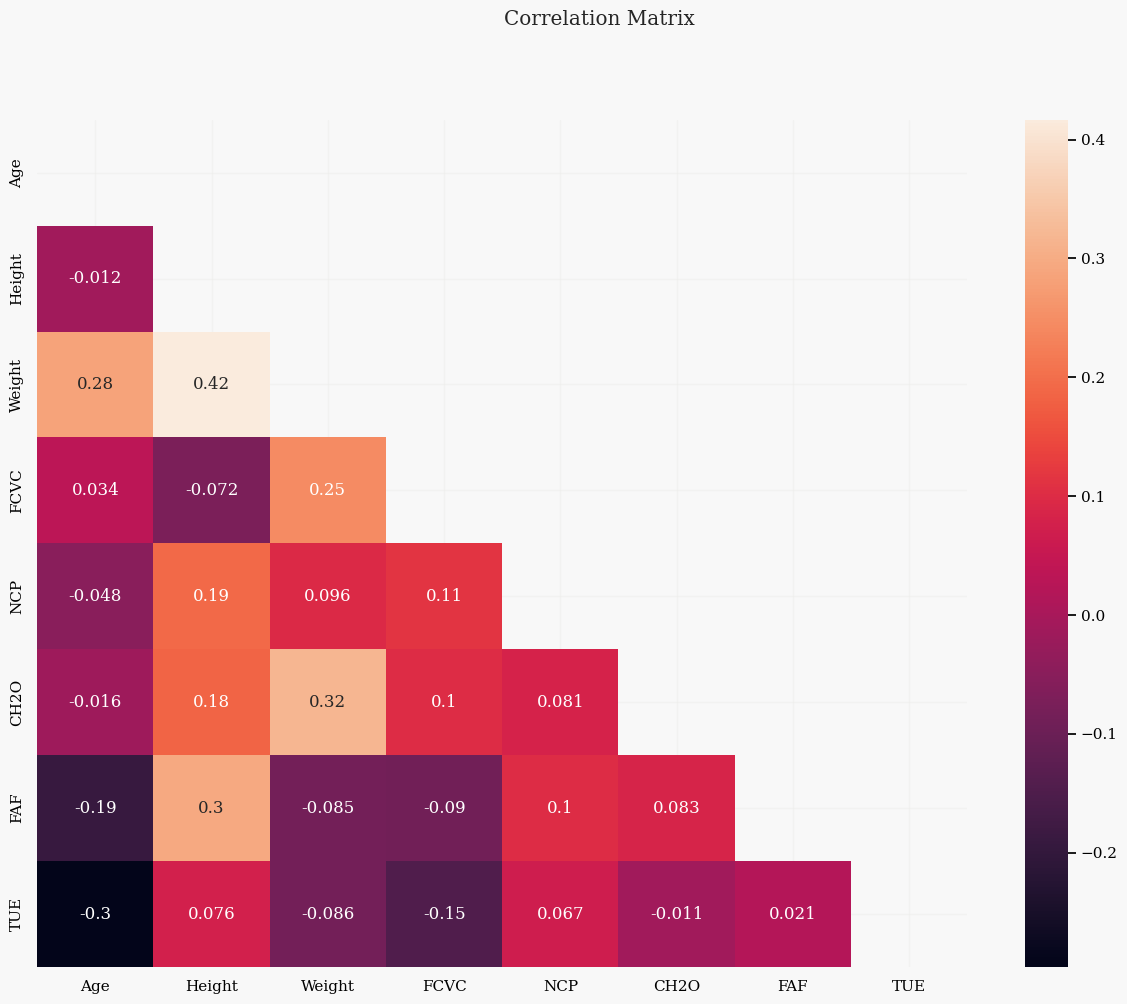

In [17]:
df = train_data[continuous_vars].copy()

corr_matrix=df.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Correlation Matrix')
plt.show()

In [18]:
X = train_data.drop(['id', 'NObeyesdad'], axis=1)
y = train_data['NObeyesdad']

In [19]:
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation


In [20]:
y.head()

0    Overweight_Level_II
1          Normal_Weight
2    Insufficient_Weight
3       Obesity_Type_III
4    Overweight_Level_II
Name: NObeyesdad, dtype: object

In [21]:
X_encoded = pd.get_dummies(X, columns=['MTRANS',
                                       'SCC',
                                       'SMOKE',
                                       'CAEC',
                                       'FAVC',
                                       'family_history_with_overweight',
                                       'Gender'])

X_encoded.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CALC,MTRANS_Automobile,...,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,FAVC_no,FAVC_yes,family_history_with_overweight_no,family_history_with_overweight_yes,Gender_Female,Gender_Male
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Sometimes,False,...,False,False,True,False,False,True,False,True,False,True
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,no,True,...,False,True,False,False,False,True,False,True,True,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,no,False,...,False,False,True,False,False,True,False,True,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Sometimes,False,...,False,False,True,False,False,True,False,True,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Sometimes,False,...,False,False,True,False,False,True,False,True,False,True


In [22]:
test_data = test_data.drop(['id'], axis=1)

X_test_encoded = pd.get_dummies(test_data, columns=['MTRANS',
                                       'SCC',
                                       'SMOKE',
                                       'CAEC',
                                       'FAVC',
                                       'family_history_with_overweight',
                                       'Gender'])

X_test_encoded.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CALC,MTRANS_Automobile,...,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,FAVC_no,FAVC_yes,family_history_with_overweight_no,family_history_with_overweight_yes,Gender_Female,Gender_Male
0,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,Sometimes,False,...,False,False,True,False,False,True,False,True,False,True
1,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,Sometimes,False,...,False,False,True,False,False,True,False,True,True,False
2,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,Sometimes,False,...,False,False,True,False,False,True,False,True,True,False
3,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,Sometimes,False,...,False,False,True,False,False,True,False,True,False,True
4,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,Sometimes,False,...,False,False,True,False,False,True,False,True,True,False


In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X_encoded.CALC = le.fit_transform(X_encoded.CALC)
X_test_encoded.CALC = le.fit_transform(X_test_encoded.CALC)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y, 
                                                    random_state=42, 
                                                    stratify=y)

In [25]:
base_model = lgb.LGBMClassifier()
base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 15568, number of used features: 28
[LightGBM] [Info] Start training from score -2.107583
[LightGBM] [Info] Start training from score -1.907537
[LightGBM] [Info] Start training from score -1.964517
[LightGBM] [Info] Start training from score -1.854860
[LightGBM] [Info] Start training from score -1.635336
[LightGBM] [Info] Start training from score -2.146381
[LightGBM] [Info] Start training from score -2.107583


In [26]:
accuracy_score(y_test, y_pred)

0.9090558766859345

In [27]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.95      0.94       631
      Normal_Weight       0.89      0.89      0.89       771
     Obesity_Type_I       0.89      0.89      0.89       727
    Obesity_Type_II       0.96      0.98      0.97       812
   Obesity_Type_III       1.00      1.00      1.00      1012
 Overweight_Level_I       0.81      0.78      0.80       607
Overweight_Level_II       0.82      0.81      0.82       630

           accuracy                           0.91      5190
          macro avg       0.90      0.90      0.90      5190
       weighted avg       0.91      0.91      0.91      5190



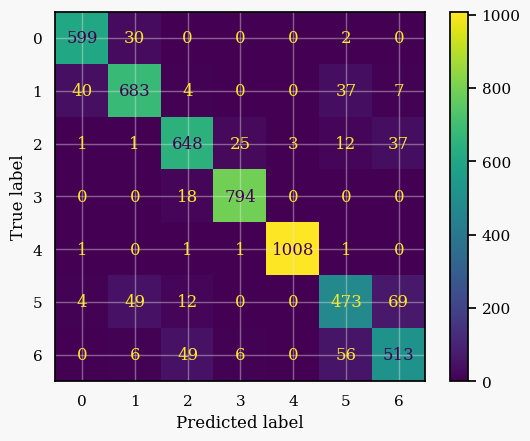

In [28]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [29]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 7,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [30]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200)

[I 2024-02-02 10:57:08,191] A new study created in memory with name: lightgbm
[I 2024-02-02 10:57:08,722] Trial 0 finished with value: 0.8537572254335261 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.8537572254335261.
[I 2024-02-02 10:57:12,099] Trial 1 finished with value: 0.9080924855491329 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 1 with value: 0.9080924855491329.
[I 2024-02-02 10:57:14,403] Trial 2 finished with value: 0.905587668593449 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.73521

In [31]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 5.406568028518286e-08, 'lambda_l2': 2.117206171801819, 'num_leaves': 228, 'feature_fraction': 0.5665344298629441, 'bagging_fraction': 0.8791239052337815, 'bagging_freq': 7, 'min_child_samples': 90}


In [32]:
print('Best value:', study.best_value)

Best value: 0.9142581888246628


In [33]:
print('Best trial:', study.best_trial)

Best trial: FrozenTrial(number=139, state=TrialState.COMPLETE, values=[0.9142581888246628], datetime_start=datetime.datetime(2024, 2, 2, 11, 3, 36, 620788), datetime_complete=datetime.datetime(2024, 2, 2, 11, 3, 39, 238493), params={'lambda_l1': 5.406568028518286e-08, 'lambda_l2': 2.117206171801819, 'num_leaves': 228, 'feature_fraction': 0.5665344298629441, 'bagging_fraction': 0.8791239052337815, 'bagging_freq': 7, 'min_child_samples': 90}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_samples': IntDistribution(hig

In [34]:
model = lgb.LGBMClassifier(lambda_l1=4.7516639792363974e-08, 
                           lambda_l2= 9.788847162667828, 
                           num_leaves= 46, 
                           feature_fraction= 0.6131121082599934, 
                           bagging_fraction= 0.9677622146367539, 
                           bagging_freq= 6, 
                           min_child_samples= 35)

model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6131121082599934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6131121082599934
[LightGBM] [Warning] lambda_l2 is set=9.788847162667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.788847162667828
[LightGBM] [Warning] lambda_l1 is set=4.7516639792363974e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7516639792363974e-08
[LightGBM] [Warning] bagging_fraction is set=0.9677622146367539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677622146367539
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6131121082599934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6131121082599934
[LightGBM] [Warning] lambda_l2 is set=9.788847162667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.788847162667828
[LightGBM] [Warning] lambda_l1 i

LGBMClassifier(bagging_fraction=0.9677622146367539, bagging_freq=6,
               feature_fraction=0.6131121082599934,
               lambda_l1=4.7516639792363974e-08, lambda_l2=9.788847162667828,
               min_child_samples=35, num_leaves=46)

In [35]:
y_pred = model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.6131121082599934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6131121082599934
[LightGBM] [Warning] lambda_l2 is set=9.788847162667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.788847162667828
[LightGBM] [Warning] lambda_l1 is set=4.7516639792363974e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7516639792363974e-08
[LightGBM] [Warning] bagging_fraction is set=0.9677622146367539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677622146367539
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [36]:
accuracy_score(y_test, y_pred)

0.9152215799614644

In [37]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.95      0.94       631
      Normal_Weight       0.90      0.89      0.90       771
     Obesity_Type_I       0.89      0.90      0.89       727
    Obesity_Type_II       0.96      0.98      0.97       812
   Obesity_Type_III       1.00      1.00      1.00      1012
 Overweight_Level_I       0.83      0.80      0.82       607
Overweight_Level_II       0.83      0.83      0.83       630

           accuracy                           0.92      5190
          macro avg       0.91      0.91      0.91      5190
       weighted avg       0.91      0.92      0.91      5190



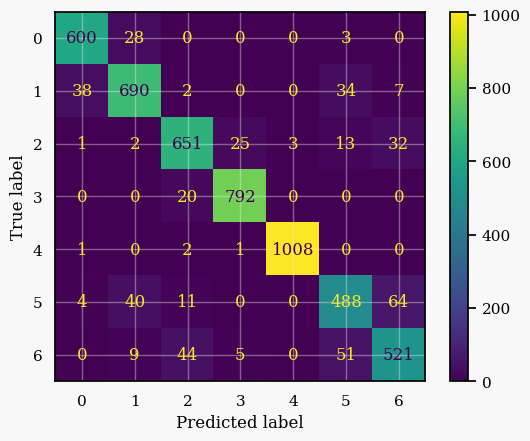

In [38]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

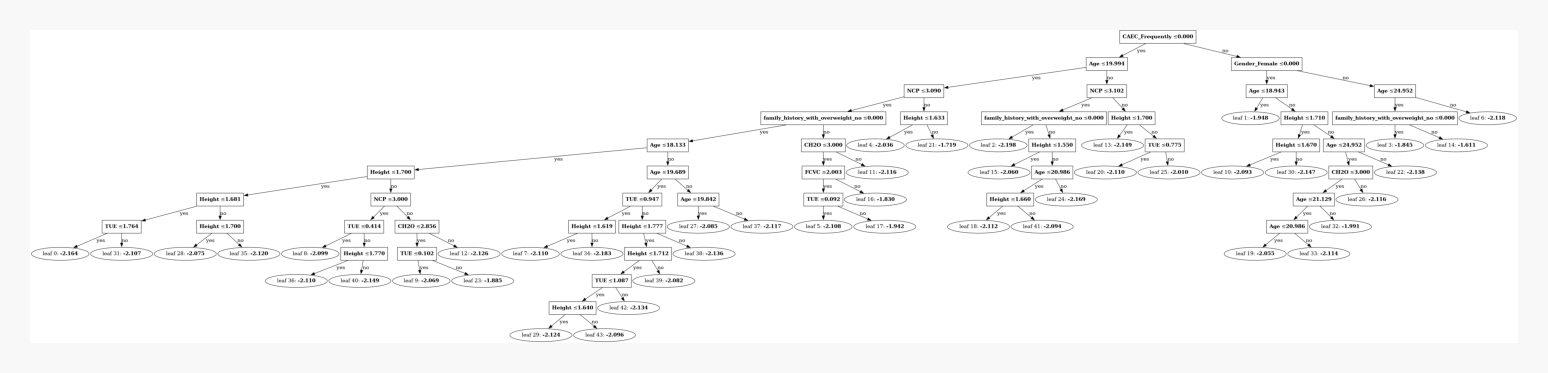

In [39]:
#fig, ax = plt.subplots(figsize=(20,10), sharex=True)
lgb.plot_tree(model, tree_index=0,dpi=300, orientation='vertical')
plt.show()

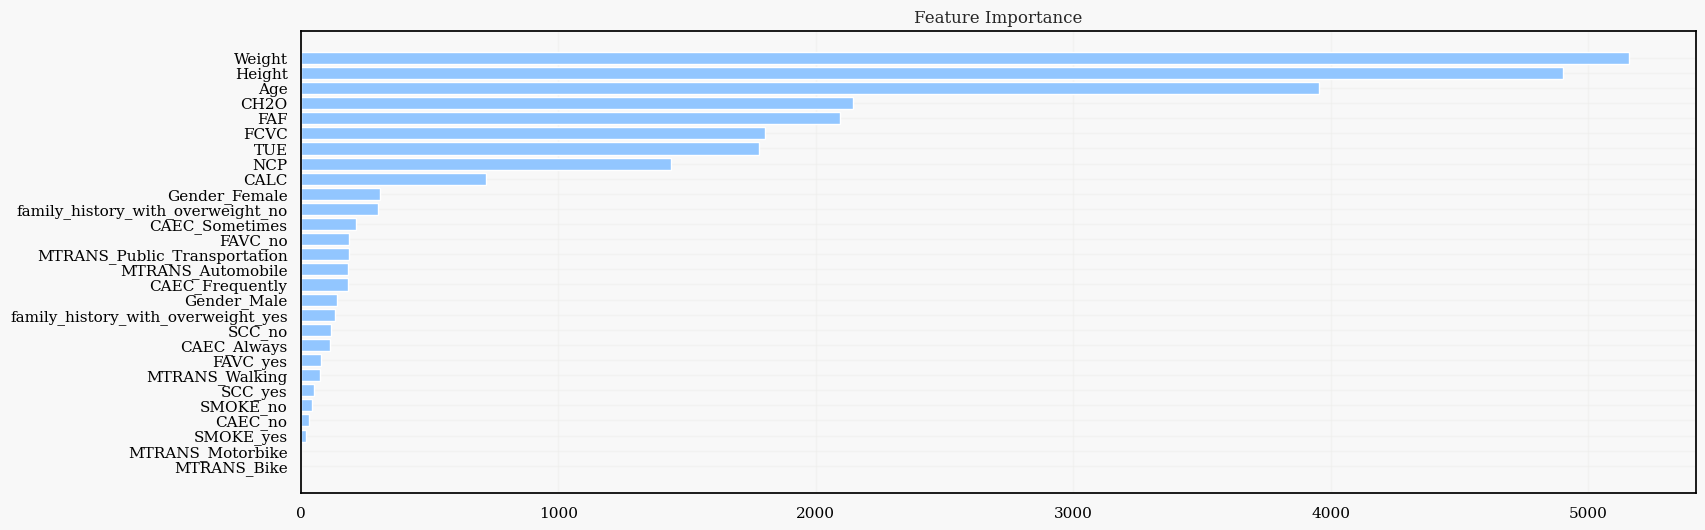

In [40]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(18, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [41]:
y_pred = model.predict(X_test_encoded)

[LightGBM] [Warning] feature_fraction is set=0.6131121082599934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6131121082599934
[LightGBM] [Warning] lambda_l2 is set=9.788847162667828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.788847162667828
[LightGBM] [Warning] lambda_l1 is set=4.7516639792363974e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7516639792363974e-08
[LightGBM] [Warning] bagging_fraction is set=0.9677622146367539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677622146367539
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [42]:
sample_submission['NObeyesdad'] = y_pred
sample_submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
